# Algorithms for Optimizations
## Chapter 4. Local Descent

In [1]:
%load_ext watermark
%watermark -v -m -p numpy,cvxpy,scipy,tqdm,matplotlib

Python implementation: CPython
Python version       : 3.7.8
IPython version      : 7.19.0

numpy     : 1.18.4
cvxpy     : 1.0.25
scipy     : 1.6.0
tqdm      : 4.51.0
matplotlib: 3.3.2

Compiler    : GCC 7.5.0
OS          : Linux
Release     : 4.4.0-176-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 16
Architecture: 64bit



In [2]:
import sys
assert sys.version_info >= (3, 7)

In [3]:
import time
import numpy as np
import cvxpy as cp
import scipy.optimize as opt
import matplotlib.pyplot as plt

from tqdm import tqdm

#### Line search
* Page 54 (Algorithm 4.1)
  * Method to determine the optimal _step size_ $\alpha$ when a descent direction $\mathbf{d}$ is already given.

In [4]:
def f(x):
    return np.sin(x[0] * x[1]) + np.exp(x[1] + x[2]) - x[2]

In [5]:
# Adpated from Ch 03.
def bracket_minimum(f, x=0, s=1e-2, k=2.0):
    a, ya = x, f(x)
    b, yb = a + s, f(a + s)
    if yb > ya:
        a, b = b, a
        ya, yb = yb, ya
        s = -s
    
    while True:
        c, yc = b + s, f(b + s)
        if yc > yb:
            return (a, c) if a < c else (c, a)
        a, ya, b, yb = b, yb, c, yc
        s *= k

In [6]:
def line_search(f, x, d):
    objective = lambda alpha: f(x + alpha * d)
    a, b = bracket_minimum(objective)
    alpha = opt.brent(objective, brack=(a, b))
    x_opt = x + alpha * d
    return alpha, x_opt, f(x_opt)

In [7]:
# Page 55
alpha, x_opt, f_opt = line_search(f, np.array([1, 2, 3]), np.array([0, -1, -1]))
print(f"[INFO] The minimum is at alpha={alpha:.3f} with x={x_opt.round(4)} and f(x)={f_opt:.3f}")

[INFO] The minimum is at alpha=3.127 with x=[ 1.    -1.127 -0.127] and f(x)=-0.491


#### Approximate line search
* Page 56 (Algorithm 4.2)
  * Approximate line search using the first Wolfe condition
  * First Wolfe condition (sufficient decrease condition; Armijo condition)
    * $f(\mathbf{x}^{(k+1)})\leq f(\mathbf{x}^{(k)})+\beta\alpha\nabla_{\mathbf{d}^{(k)}}{f(\mathbf{x}^{(k)})}$
    * Insufficient to guarantee convergence to a local minimum since a very small step size is still acceptable

In [8]:
def backtracking_line_search(f, f_grad, x, d, alpha, p=0.5, beta=1e-4):
    y, g = f(x), f_grad(x)
    while f(x + alpha * d) > y + beta * alpha * np.dot(g, d):
        alpha *= p
    x_new = x + alpha * d
    return alpha

* Page 57 (Not stated in the book, but for example 4.2)
  * Approximate line search using both the first Wolfe condition and the second Wolfe condition
  * Second Wolfe condition (curvature condition)
    * $\nabla_{\mathbf{d}^{(k)}}{f(\mathbf{x}^{(k+1)})}\geq\sigma\nabla_{\mathbf{d}^{(k)}}{f(\mathbf{x}^{(k)})}$
    * Directional derivative should be increased in some degree to make a progress

In [9]:
def backtracking_line_search_two(f, f_grad, x, d, alpha, p=0.5, beta=1e-4, sigma=0.9):
    y, g = f(x), f_grad(x)
    
    # Adjust the maximum step size, alpha, until it meets the first Wolfe condition
    while f(x + alpha * d) > y + beta * alpha * np.dot(g, d):
        alpha *= p
        
    x_new = x + alpha * d
    # Check if the adjusted design point satisfies the second Wolfe condition
    while np.dot(d, f_grad(x_new)) < sigma * np.dot(d, f_grad(x)):
        alpha *= p
        x_new = x + alpha * d
    return alpha

* Page 58 (Example 4.2)

In [10]:
def f_example_4_2(x):
    return x[0]**2 + x[0] * x[1] + x[1]**2

def f_example_4_2_grad(x):
    return np.array([2 * x[0] + x[1], x[0] + 2 * x[1]])

In [11]:
alpha_first = backtracking_line_search(f_example_4_2, f_example_4_2_grad, np.array([1, 2]), np.array([-1, -1]), 10)
print(f"[INFO] Step size alpha: {alpha_first:.4f} when applying the first Wolfe condition")

[INFO] Step size alpha: 2.5000 when applying the first Wolfe condition


In [12]:
alpha_both = backtracking_line_search_two(f_example_4_2, f_example_4_2_grad, np.array([1, 2]), np.array([-1, -1]), 10)
print(f"[INFO] Step size alpha: {alpha_both:.4f} when applying the first and the second Wolfe condition")

[INFO] Step size alpha: 2.5000 when applying the first and the second Wolfe condition


* Page 62 (Algorithm 4.3)
  * Strong Wolfe condition (curvature condition)
    * $\lvert\nabla_{\mathbf{d}^{(k)}}{f(\mathbf{x}^{(k+1)})}\rvert\leq\sigma\lvert\nabla_{\mathbf{d}^{(k)}}{f(\mathbf{x}^{(k)})}\rvert$
    * Directional derivative should not become to be too positive

In [13]:
def strong_backtracking(f, f_grad, x, d, alpha=1, beta=1e-4, sigma=0.1):
    y0, g0, y_prev, alpha_prev = f(x), np.dot(f_grad(x), d), np.nan, 0
    alpha_lo, alpha_hi = np.nan, np.nan
    
    # Bracket phase
    while True:
        y = f(x + alpha * d)
        if y > y0 + beta * alpha * g0 or (np.isnan(y_prev) & (y >= y_prev)):
            alpha_lo, alpha_hi = alpha_prev, alpha
            break
        g = np.dot(d, f_grad(x + alpha * d))
        if np.abs(g) <= -sigma * g0:
            return alpha
        elif g >= 0:
            alpha_lo, alpha_hi = alpha, alpha_prev
            break
        y_prev, alpha_prev, alpha = y, alpha, 2 * alpha
        
    # Zoom phase
    y_lo = f(x + alpha_lo * d)
    while True:
        alpha = (alpha_lo + alpha_hi) / 2
        y = f(x + alpha * d)
        if y > y0 + beta * alpha * g0 or y >= y_lo:
            alpha_hi = alpha
        else:
            g = np.dot(d, f_grad(x + alpha * d))
            if np.abs(g) <= -sigma * g0:
                return alpha
            elif g * (alpha_hi - alpha_lo) >= 0:
                alpha_hi = alpha_lo
            alpha_lo = alpha

In [14]:
alpha_strong = strong_backtracking(f_example_4_2, f_example_4_2_grad, np.array([1, 2]), np.array([-1, -1]), 10)
print(f"[INFO] Step size alpha: {alpha_strong:.4f} when applying the strong Wolfe condition")

[INFO] Step size alpha: 1.5625 when applying the strong Wolfe condition


#### Trust region method
* Page 64 (Algorithm 4.4)
  * Set the maximum step size first and the the step direction

In [15]:
def solve_trust_region_subproblem(f_grad, H, x0, delta):
    x = cp.Variable(x0.shape)
    objective = cp.Minimize((x - x0).T @ f_grad(x0) + cp.quad_form(x - x0, H(x0)) * 0.5)
    constraints = [cp.norm(x - x0) <= delta]
    problem = cp.Problem(objective, constraints)
    problem.solve()
    return x.value, problem.value

def trust_region_descent(f, f_grad, H, x, k_max, eta1=0.4, eta2=0.6, gamma1=0.5, gamma2=1.05, delta=1.0):
    pts, rads = [], []
    
    y = f(x)
    for k in tqdm(range(k_max)):
        x_, y_ = solve_trust_region_subproblem(f_grad, H, x, delta)
        r = (y - f(x_)) / (y - y_)
        if r < eta1:
            delta *= gamma1
        else:
            x, y = x_, y_
            if r > eta2:
                delta *= gamma2
        pts.append(x_)
        rads.append(delta)
    return x_, pts, rads

In [16]:
def rosenbrock(x, b=5):
    return (x[0] - 1)**2 + b * (x[1] - x[0]**2)**2

In [17]:
def rosenbrock_grad(x, b=5):
    return np.array([2 * (x[0] - 1) - 4 * b * (x[1] - x[0]**2) * x[0], 2 * b * (x[1] - x[0]**2)])

In [18]:
def rosenbrock_hess(x, b=5):
    return np.array([[2 - 4 * b * x[1] + 12 * b * x[0]**2, -4 * b * x[0]]\
                     ,[-4 * b * x[0], 2 * b]])

In [19]:
x0 = np.array([-1.0, 0.0])
x_opt, pts_path, rads_path = trust_region_descent(rosenbrock, rosenbrock_grad, rosenbrock_hess, np.array([-1.0, 0.0]), 10)
print(f"[INFO] Optimal trust region is: central point ({x_opt[0]:.4f},{x_opt[1]:.4f}) with radius {rads_path[-1]:.4f}")

100%|██████████| 10/10 [00:00<00:00, 83.57it/s]

[INFO] Optimal trust region is: central point (1.0000,0.9999) with radius 0.7387


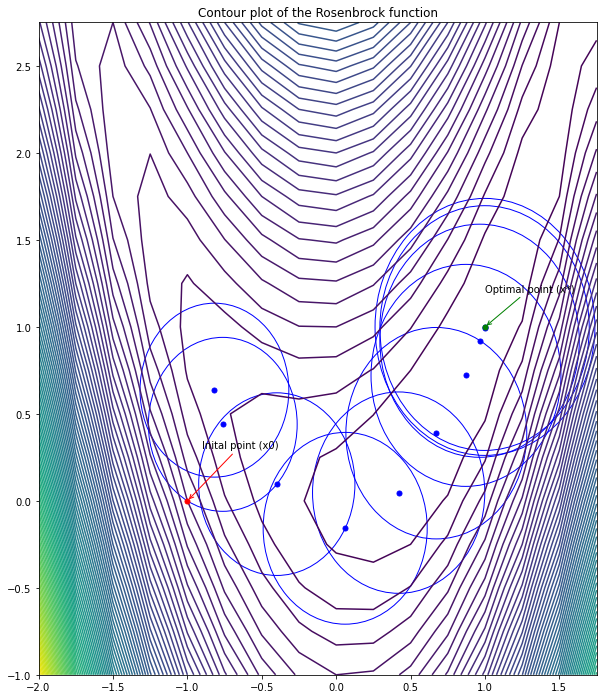

In [20]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 12)

x = np.arange(-2, 2, 0.25)
y = np.arange(-1, 3, 0.25)
z = rosenbrock(np.meshgrid(x, y))

ax.contour(x, y, z, levels=100)
ax.plot(*x0, marker='o', markersize=5, color='r')
ax.annotate('Inital point (x0)', xy=x0, xytext=(-0.9, 0.3), arrowprops={'arrowstyle': '->', 'color': 'red'})

for point, radius in zip(pts_path, rads_path):
    ax.plot(*point, marker='o', markersize=5, color='b')
    trust_region = plt.Circle(point, radius, color='b', fill=False)
    ax.add_artist(trust_region)
ax.plot(*pts_path[-1], marker='o', markersize=5, color='g')
ax.annotate('Optimal point (x*)', xy=pts_path[-1], xytext=(1.0, 1.2), arrowprops={'arrowstyle': '->', 'color': 'green'})
ax.set_title("Contour plot of the Rosenbrock function")

plt.show()